# Setup

## Imports

In [1]:
import os.path
import cupy as cp

from glob import glob
from skimage.transform import resize
from tqdm import tqdm_notebook
from glob import glob

vai Modules

In [2]:
from vaiutils import path_consts, plot_images

Keras Modules

In [3]:
import keras.backend as K

Using TensorFlow backend.
/home/vaisakh/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Define Useful Variables and Constants

In [4]:
def limit_mem():
    '''try:
        K.get_session().close()
    except:
        K.clear_session()'''
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

limit_mem()

In [5]:
for k, v in path_consts('COCO'):
    exec(k+'=v')

Custom Modules

In [6]:
from colorizer import rgb_to_lab, lab_to_rgb

In [7]:
pixel = K.placeholder((None, None, 3))
rgb2lab = K.Function([pixel], [rgb_to_lab(pixel)])
lab2rgb = K.Function([pixel], [lab_to_rgb(pixel)])

In [8]:
def softmax(x):
    x -= x.max(-1, keepdims=True)
    x = cp.exp(x)
    return x / x.sum(-1, keepdims=True)

## Checks

In [ ]:
assert not os.path.exists(os.path.join(DIR_CHECKPOINTS, 'class_weights.npy')), 'Weights already created.\nYou can exit the notebook'

In [10]:
assert os.path.exists(os.path.join(DIR_CHECKPOINTS, 'ab_bins.npy')), 'Gamut Bins not created/found.\nRun GamutBins Notebook first'

## Load Data

In [11]:
ab_bins = np.load(os.path.join(DIR_CHECKPOINTS, 'ab_bins.npy'))
Q = len(ab_bins)

In [12]:
filenames = glob(os.path.join(DIR_DATA, 'val2017', '*.jpg'))

# Find Probabilities

## Remove False Bins

In [14]:
bins = cp.array(ab_bins)

In [15]:
bin_counts = np.zeros(Q, dtype=np.uint64)

In [16]:
for filename in tqdm_notebook(filenames):
    img = resize(imread(filename), (224, 224), mode='constant') * 255
    img_lab = cp.array(rgb2lab([img/255])[0])
    distances = cp.linalg.norm(cp.repeat(cp.expand_dims(cp.take(img_lab, [1, 2], -1), -1), Q, -1) - bins.T, axis=-2)

    counts = np.unique(cp.asnumpy(distances.argmin(-1)), return_counts=True)
    bin_counts[counts[0]] += counts[1].astype(uint64)

HBox(children=(IntProgress(value=0, max=4863), HTML(value='')))

In [17]:
ab_bins = ab_bins[bin_counts != 0]
Q = len(ab_bins)
np.save(os.path.join(DIR_CHECKPOINTS, 'ab_bins'), ab_bins)

In [19]:
bin_counts = bin_counts[bin_counts != 0]

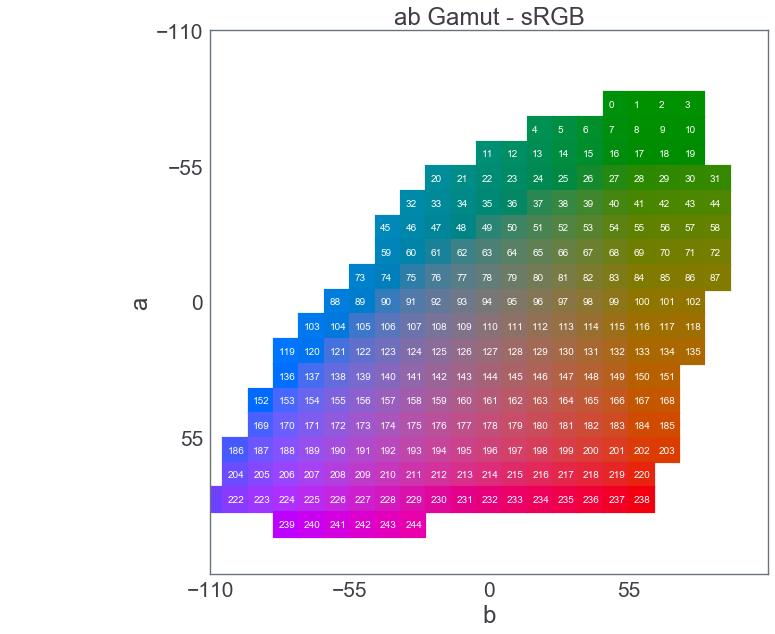

In [27]:
lab_gamut = np.ones((ab_bins.shape[0], 3)) * 50
lab_gamut[:, 1:] = ab_bins
    
color_gamut = lab2rgb([np.expand_dims(lab_gamut, 0)])[0][0]
        
plt.scatter(ab_bins[:, 1], ab_bins[:, 0], 700, color_gamut,'s')
for i in range(len(ab_bins)):
    plt.annotate(str(i), (ab_bins[i, 1] - 3, ab_bins[i, 0] + 1), size=10, color='w')
plt.xlabel('b')
plt.ylabel('a')
plt.xlim(-110, 110)
plt.ylim(-110, 110)
plt.xticks(np.arange(-110, 110, 55))
plt.yticks(np.arange(-110, 110, 55))
plt.gca().invert_yaxis()
plt.gcf().set_size_inches((10, 10))
plt.title('ab Gamut - sRGB')
plt.grid('off')
plt.savefig(os.path.join(DIR_OUTPUT, 'ab_gamut.jpg'), dpi=400)
plt.show()

In [28]:
probabilities = bin_counts / (len(filenames) * 224 ** 2)

In [29]:
def plot_rarity(log_probs, savetitle=''):
    plt.scatter(ab_bins[:, 1], ab_bins[:, 0], 800, log_probs, marker='s', cmap='jet')
    plt.xlabel('b')
    plt.ylabel('a')
    plt.xlim(-110, 110)
    plt.ylim(-110, 110)
    plt.xticks(np.arange(-110, 110, 55))
    plt.yticks(np.arange(-110, 110, 55))
    plt.gca().invert_yaxis()
    plt.gcf().set_size_inches((12, 10))
    plt.title(savetitle)
    plt.grid('off')
    plt.colorbar()
    if len(savetitle) > 0:
        plt.savefig( os.path.join(DIR_OUTPUT, savetitle + '.jpg'), dpi=400)
    plt.show()

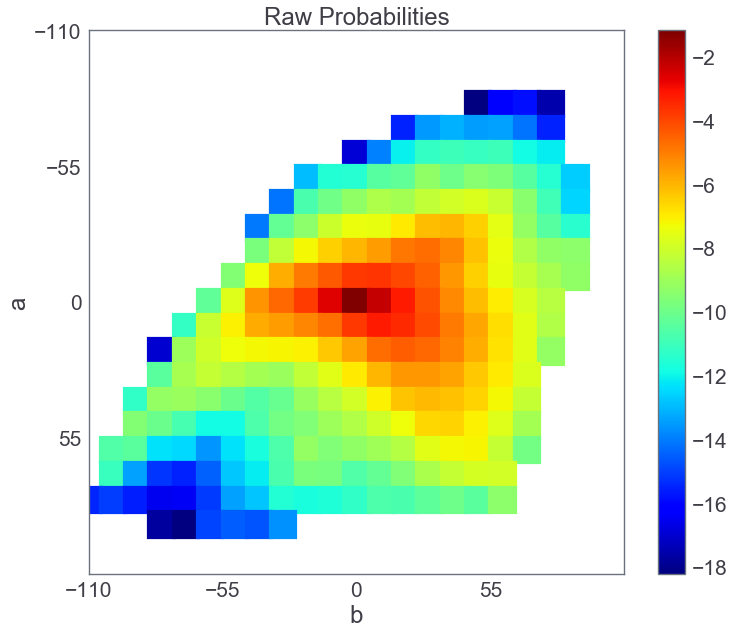

In [30]:
plot_rarity(np.log(probabilities), 'Raw Probabilities')

## Smoothened Probabilities

In [31]:
sigma = 5

In [32]:
smooth_probabilities = cp.zeros(Q)
bins = cp.array(ab_bins)

In [33]:
for filename in tqdm_notebook(filenames):
    img = resize(imread(filename), (224, 224), mode='constant') * 255
    img_lab = cp.array(rgb2lab([img / 255]))[0]
    distances = cp.linalg.norm(cp.repeat(cp.expand_dims(cp.take(img_lab, [1, 2], -1), -1), Q, -1) - bins.T, axis=-2)
    
    distances = distances.reshape(-1, Q)
    smooth_probabilities += softmax(-distances ** 2 / (2 * sigma ** 2)).mean(0)

HBox(children=(IntProgress(value=0, max=4863), HTML(value='')))

In [34]:
smooth_probabilities /= len(filenames)
smooth_probabilities = cp.asnumpy(smooth_probabilities)

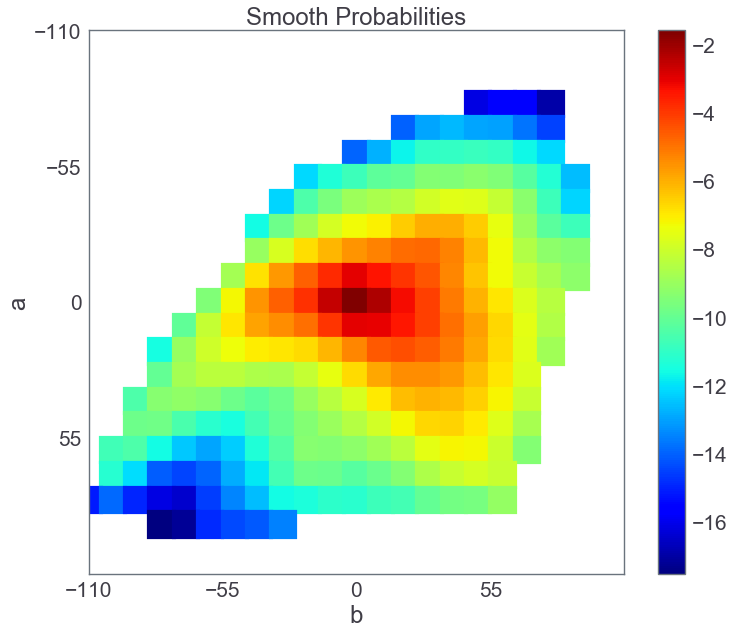

In [35]:
plot_rarity(np.log(smooth_probabilities), 'Smooth Probabilities')

## Define Weights

In [36]:
weights = 2 / (smooth_probabilities + 1 / Q)
weights /= (weights * smooth_probabilities).sum()

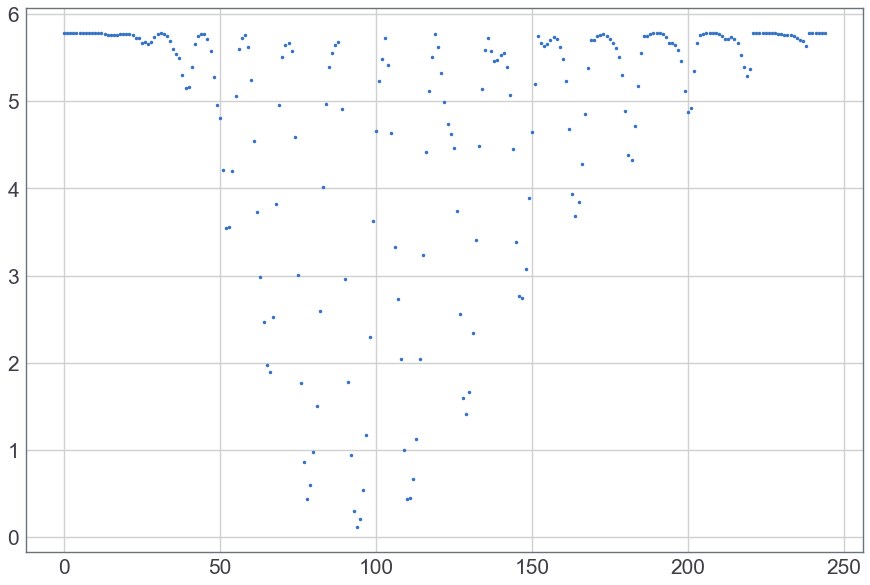

In [37]:
plot(weights, '.')

In [38]:
np.save(os.path.join(DIR_CHECKPOINTS, 'class_weights'), weights)